In [1]:
#Generic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm import tqdm
import os
import time
import datetime
import pickle
## pytorch packages
from tqdm import auto
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from torch.utils.data import ConcatDataset

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, global_mean_pool, TopKPooling, SAGPooling, GATConv
from torch_geometric.data import Batch
from torch.nn import BatchNorm1d
from torch_geometric.nn import HANConv, HeteroConv
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import roc_auc_score, f1_score

c:\Users\Joe\miniconda3\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [47]:
train_graphs = pickle.load(open('train_graphs.pickle', 'rb'))
test_graphs = pickle.load(open('test_graphs.pickle', 'rb'))

In [63]:

player_in_channels = train_graphs[0]['player'].x.size(1) #### dimension of player features
team_in_channels = train_graphs[0]['team'].x.size(1)   ### dimension of team features
edge_in_channels = 37

hidden_channels = 24 ####hidden dim

num_classes = 2 ###binary classification

#in_channels = {'team': team_in_channels + hidden_channels, 'player': player_in_channels} ###input for HANConv layer #### Use when concatenating the edge features to team features
in_channels = {'team': team_in_channels, 'player': player_in_channels} ###input for HANConv layer #### Use when concatenating the edge features to team and player features at the end
heads = 4  ###attention heads

batch_size = 16
dropout = 0.25
#train_dataset, val_dataset = random_split(train_graphs_modified, [train_dataset_size, val_dataset_size])

print(player_in_channels)
print(team_in_channels)



46
22


In [49]:

with open('train_dataset.pickle', 'rb') as f:
    train_dataset = pickle.load(f)

with open('val_dataset.pickle', 'rb') as f:
    val_dataset = pickle.load(f)

with open('test_dataset.pickle', 'rb') as f:
    test_dataset = pickle.load(f)



In [50]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [51]:
train_dataset_graphs = train_dataset.dataset
val_dataset_graphs = val_dataset.dataset

full_train_dataset = ConcatDataset([train_dataset_graphs, val_dataset_graphs])
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)



In [80]:
#### MODELS ####

class TClassifier(torch.nn.Module):
    def __init__(self, team_in_channels, hidden_channels, edge_in_channels,num_classes,  dropout = 0.5):
        super(TClassifier, self).__init__()
        
       
        #self.conv1 = HANConv(in_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        #self.conv2 = HANConv(hidden_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        
        #self.edge_transform = Linear(edge_in_channels, hidden_channels)
        #self.team_linear = Linear(hidden_channels, hidden_channels)
        #self.team_bn = BatchNorm1d(hidden_channels)
        #self.player_linear = Linear(hidden_channels, hidden_channels)
        #self.player_bn = BatchNorm1d(hidden_channels)
        #self.teampool = SAGPooling(hidden_channels, ratio=0.5)
        #self.playerpool = SAGPooling(hidden_channels, ratio=0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.02)
        self.post_cat = Linear((team_in_channels+team_in_channels+edge_in_channels), hidden_channels)
        self.post_cat_bn = BatchNorm1d(hidden_channels)
        self.final_linear = Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        self.light_dropout = torch.nn.Dropout(dropout/2)
        #self.sag_pool = sag_pool
        #self.test_layer_team =Linear(278, hidden_channels)
        #self.test_layer_player = Linear(46, hidden_channels)
        

        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x_dict, data.edge_index_dict, data.edge_attr_dict[('team','to','team')]
        team_batch = data['team'].batch

        #x_player = global_mean_pool(x['player'], data['player'].batch)
        #print(x_player.shape)

        output_list = []
        for i in range(data.num_graphs):
            x_i = torch.cat((x['team'][2*i], x['team'][2*i+1]), dim=-1)
            edge_attr_i = edge_attr[i]

            x_i = torch.cat((x_i, edge_attr_i), dim=-1)
            #x_i = torch.cat((x_i, x_player[i]), dim=-1)
            output_list.append(x_i)

        x = torch.stack(output_list)
        x = self.post_cat(x)
        x = self.post_cat_bn(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.final_linear(x)
        return x




class TPClassifier(torch.nn.Module):
    def __init__(self, team_in_channels, hidden_channels, edge_in_channels,num_classes,  dropout = 0.5):
        super(TPClassifier, self).__init__()
        
       
        #self.conv1 = HANConv(in_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        #self.conv2 = HANConv(hidden_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        
        self.edge_transform = Linear(edge_in_channels, hidden_channels)
        self.team_linear = Linear(hidden_channels, hidden_channels)
        self.team_bn = BatchNorm1d(hidden_channels)
        self.player_linear = Linear(hidden_channels, hidden_channels)
        self.player_bn = BatchNorm1d(hidden_channels)
        self.teampool = SAGPooling(hidden_channels, ratio=0.5)
        self.playerpool = SAGPooling(hidden_channels, ratio=0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.02)
        self.post_cat = Linear((team_in_channels+team_in_channels+edge_in_channels+46+46), hidden_channels)
        self.post_cat_bn = BatchNorm1d(hidden_channels)
        self.final_linear = Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        self.light_dropout = torch.nn.Dropout(dropout/2)
        #self.sag_pool = sag_pool
        #self.test_layer_team =Linear(278, hidden_channels)
        #self.test_layer_player = Linear(46, hidden_channels)
        

        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x_dict, data.edge_index_dict, data.edge_attr_dict[('team','to','team')]
        team_batch = data['team'].batch
        player_batch = data['player'].batch
        player_to_team_edge_index = data.edge_index_dict[('player', 'to', 'team')]

        home_player_indices = (player_to_team_edge_index[1] % 2 == 0).nonzero(as_tuple=True)[0]
        away_player_indices = (player_to_team_edge_index[1] % 2 == 1).nonzero(as_tuple=True)[0]

        # Extract home and away player features
        x_player_home = x['player'][home_player_indices]
        x_player_away = x['player'][away_player_indices]

        # Perform pooling separately for home and away players
        x_player_home_pooled = global_mean_pool(x_player_home, player_batch[home_player_indices])
        x_player_away_pooled = global_mean_pool(x_player_away, player_batch[away_player_indices])

        #print(x_player_home_pooled.shape)
        #print(x_player_away_pooled.shape)


        #x_player = global_mean_pool(x['player'], data['player'].batch)
        #print(x_player.shape)

        output_list = []
        for i in range(data.num_graphs):
            x_i = torch.cat((x['team'][2*i], x['team'][2*i+1]), dim=-1)
            edge_attr_i = edge_attr[i]

            x_i = torch.cat((x_i, edge_attr_i), dim=-1)
            #print(x_i.shape)
            x_i = torch.cat((torch.cat((x_i, x_player_home_pooled[i]), dim=-1), x_player_away_pooled[i]), dim=-1)
            #print(x_i.shape)
            output_list.append(x_i)

        x = torch.stack(output_list)
        x = self.post_cat(x)
        x = self.post_cat_bn(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.final_linear(x)
        return x


class TPHeteroClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_in_channels,num_classes, heads, dropout = 0.5,sag_pool=True):
        super(TPHeteroClassifier, self).__init__()
        def team_aggr(x, x_dict, size):
            return x_dict['team'].mean(dim=1)

        def player_aggr(x, x_dict, size):
            return x_dict['player'].mean(dim=1)
        self.hconv1 = HeteroConv(
            {
                ('team', 'to', 'team'): GCNConv(in_channels['team'], hidden_channels),
                ('player', 'to', 'player'): GCNConv(in_channels['player'], hidden_channels)
            },
            train_graphs[0].metadata()
        )
        
        self.hconv2 = HeteroConv({
                ('team', 'to', 'team'): GCNConv(hidden_channels, hidden_channels),
                ('player', 'to', 'player'): GCNConv(hidden_channels, hidden_channels)
            },
            train_graphs[0].metadata()
        )
        #self.conv1 = HANConv(in_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)

        #self.conv2 = HANConv(hidden_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        
        self.edge_transform = Linear(edge_in_channels, hidden_channels)
        
        self.team_linear = Linear(hidden_channels, hidden_channels)
        self.team_bn = BatchNorm1d(hidden_channels)
        
        self.player_linear = Linear(hidden_channels, hidden_channels)
        self.player_bn = BatchNorm1d(hidden_channels)
        self.teampool = SAGPooling(hidden_channels, ratio=0.5)
        self.playerpool = SAGPooling(hidden_channels, ratio=0.5)
        
        self.leaky_relu = torch.nn.LeakyReLU(0.02)
        
        self.post_cat = Linear(hidden_channels*5, hidden_channels)
        
        self.post_cat_bn = BatchNorm1d(hidden_channels)
        
        self.final_linear = Linear(hidden_channels, num_classes)
        
        self.dropout = torch.nn.Dropout(dropout)
        self.light_dropout = torch.nn.Dropout(dropout/2)
        
        self.sag_pool = sag_pool
        #self.test_layer_team =Linear(278, hidden_channels)
        #self.test_layer_player = Linear(46, hidden_channels)
        

        self.lin = torch.nn.Linear(hidden_channels, num_classes)
    
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x_dict, data.edge_index_dict, data.edge_attr_dict[('team','to','team')]
        #print(x['team'].device)
        team_batch = data['team'].batch
        #print(team_batch.device)
        player_batch = data['player'].batch
        edge_attr = self.leaky_relu(self.edge_transform(edge_attr))

    
        x= self.hconv1(x, edge_index)
        #x= self.hconv2(x, edge_index)
        #x= self.conv2(x, edge_index)
        
        player_to_team_edge_index = data.edge_index_dict[('player', 'to', 'team')]

        home_player_indices = (player_to_team_edge_index[1] % 2 == 0).nonzero(as_tuple=True)[0]
        away_player_indices = (player_to_team_edge_index[1] % 2 == 1).nonzero(as_tuple=True)[0]

        # Extract home and away player features
        x_player_home = x['player'][home_player_indices]
        x_player_away = x['player'][away_player_indices]

        # Perform pooling separately for home and away players
        x_player_home_pooled = global_mean_pool(x_player_home, player_batch[home_player_indices])
        x_player_away_pooled = global_mean_pool(x_player_away, player_batch[away_player_indices])

        output_list = []
        for i in range(data.num_graphs):
            x_i = torch.cat((x['team'][2*i], x['team'][2*i+1]), dim=-1)
            edge_attr_i = edge_attr[i]

            x_i = torch.cat((x_i, edge_attr_i), dim=-1)
            x_i = torch.cat((torch.cat((x_i, x_player_home_pooled[i]), dim=-1), x_player_away_pooled[i]), dim=-1)
            output_list.append(x_i)
        x = torch.stack(output_list)
        #print(x_team.shape)
        
       
        #print(x.shape)
        x = self.post_cat(x)
        x = self.post_cat_bn(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.final_linear(x)
        #x = F.softmax(x, dim=-1)
       
        return x


class TPGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_in_channels,num_classes, heads, dropout = 0.5,sag_pool=True):
        super(TPGraphClassifier, self).__init__()
        
       
        self.conv1 = HANConv(in_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        self.conv2 = HANConv(hidden_channels, hidden_channels, metadata = train_graphs[0].metadata(),heads=heads)
        
        self.edge_transform = Linear(edge_in_channels, hidden_channels)
        
        self.team_linear = Linear(hidden_channels, hidden_channels)
        self.team_bn = BatchNorm1d(hidden_channels)
        
        self.player_linear = Linear(hidden_channels, hidden_channels)
        self.player_bn = BatchNorm1d(hidden_channels)
        self.teampool = SAGPooling(hidden_channels, ratio=0.5)
        self.playerpool = SAGPooling(hidden_channels, ratio=0.5)
        
        self.leaky_relu = torch.nn.LeakyReLU(0.02)
        
        self.post_cat = Linear(hidden_channels*5, hidden_channels)
        
        self.post_cat_bn = BatchNorm1d(hidden_channels)
        
        self.final_linear = Linear(hidden_channels, num_classes)
        
        self.dropout = torch.nn.Dropout(dropout)
        self.light_dropout = torch.nn.Dropout(dropout/2)
        
        self.sag_pool = sag_pool
        #self.test_layer_team =Linear(278, hidden_channels)
        #self.test_layer_player = Linear(46, hidden_channels)
        

        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x_dict, data.edge_index_dict, data.edge_attr_dict[('team','to','team')]
        #print(x['team'].device)
        team_batch = data['team'].batch
        #print(team_batch.device)
        player_batch = data['player'].batch
        edge_attr = self.leaky_relu(self.edge_transform(edge_attr))

    
        x= self.conv1(x, edge_index)
        #x= self.conv2(x, edge_index)
        
        player_to_team_edge_index = data.edge_index_dict[('player', 'to', 'team')]

        home_player_indices = (player_to_team_edge_index[1] % 2 == 0).nonzero(as_tuple=True)[0]
        away_player_indices = (player_to_team_edge_index[1] % 2 == 1).nonzero(as_tuple=True)[0]

        #Extract home and away player features
        x_player_home = x['player'][home_player_indices]
        x_player_away = x['player'][away_player_indices]

        #pooling separately makes more sense and performs better in MLP
        x_player_home_pooled = global_mean_pool(x_player_home, player_batch[home_player_indices])
        x_player_away_pooled = global_mean_pool(x_player_away, player_batch[away_player_indices])

        output_list = []
        for i in range(data.num_graphs):
            x_i = torch.cat((x['team'][2*i], x['team'][2*i+1]), dim=-1)
            edge_attr_i = edge_attr[i]

            x_i = torch.cat((x_i, edge_attr_i), dim=-1)
            x_i = torch.cat((torch.cat((x_i, x_player_home_pooled[i]), dim=-1), x_player_away_pooled[i]), dim=-1)
            output_list.append(x_i)
        x = torch.stack(output_list)
        #print(x_team.shape)
        
       
        #print(x.shape)
        x = self.post_cat(x)
        x = self.post_cat_bn(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.final_linear(x)
        #x = F.softmax(x, dim=-1)
       
        return x
    

In [132]:
Tmodel = TClassifier(team_in_channels=team_in_channels,hidden_channels=hidden_channels, edge_in_channels=edge_in_channels, num_classes=num_classes,  dropout = dropout).to(device)
TPmodel = TPClassifier(team_in_channels=team_in_channels,hidden_channels=hidden_channels, edge_in_channels=edge_in_channels, num_classes=num_classes,  dropout = dropout).to(device)
TPHetero_model = TPHeteroClassifier(in_channels=in_channels,hidden_channels=hidden_channels, edge_in_channels=edge_in_channels, num_classes=num_classes, heads=4, dropout = dropout).to(device)
TPHAN_model = TPGraphClassifier(in_channels, hidden_channels, edge_in_channels, num_classes, heads=heads, dropout = dropout, sag_pool=True).to(device)

In [ ]:
'''
epochs = 100

lr = 0.01
weight_decay = 5e-4

from generic_train import train
optimizer= torch.optim.Adam(Tmodel.parameters(), lr=.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer, gamma=0.99)
Tmodel = Tmodel.to(device)
best_val_accuracy_t, best_val_epoch_t, best_val_model_t = train(Tmodel, train_loader, val_loader, device, optimizer, criterion, scheduler, epochs, return_val=True, print_train = True, print_val = True)
print("Best validation accuracy: ", best_val_accuracy_t, " at epoch: ", best_val_epoch_t)
#### Next save this model into our final models folder
#torch.save(best_val_model_t, f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\t_model.pt')
torch.save(Tmodel.state_dict(), f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\t_model.pt')

'''

In [135]:
#### Load all models and test on test set
Tmodel.load_state_dict(torch.load(f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\t_model.pt'))
TPmodel.load_state_dict(torch.load(f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\tp_model.pt'))
TPHetero_model.load_state_dict(torch.load(f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\TPHetero_model.pt'))
TPHAN_model.load_state_dict(torch.load(f'C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\HANConv_model.pt'))

<All keys matched successfully>

In [136]:
from test_eval import evaluate

In [137]:
models = [Tmodel, TPmodel, TPHetero_model, TPHAN_model]

results = {'Loss': [], 'Accuracy': [], 'AUROC': [], 'F1': [], 'Model': []}


In [138]:

for model in models:
    loss, accuracy, auroc, f1 = evaluate(model, test_loader, device)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['AUROC'].append(auroc)
    results['F1'].append(f1)
    results['Model'].append(model.__class__.__name__)
    

In [144]:
results_df = pd.DataFrame(results, index=results['Model'])
results_df = results_df.drop(columns=['Model'])
results_df

,Loss,Accuracy,AUROC,F1
TClassifier,0.604658,0.652,0.662934,0.725624
TPClassifier,0.565531,0.698,0.671193,0.742222
TPHeteroClassifier,0.580840,0.711,0.652249,0.757322
TPGraphClassifier,0.544504,0.721,0.701241,0.763393


In [ ]:
### save the final results df to a csv
results_df.to_csv('C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\results_df.csv')

In [3]:
results_df = pd.read_csv('C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\Final Models\\results_df.csv')

In [6]:
results_df['Model'] = ['TT-FNN', 'TTP-FNN','HeteroConv','HANConv']
results_df

,Unnamed: 0,Loss,Accuracy,AUROC,F1,Model
0,TClassifier,0.604658,0.652,0.662934,0.725624,TT-FNN
1,TPClassifier,0.565531,0.698,0.671193,0.742222,TTP-FNN
2,TPHeteroClassifier,0.580840,0.711,0.652249,0.757322,HeteroConv
3,TPGraphClassifier,0.544504,0.721,0.701241,0.763393,HANConv


In [7]:
paper_results_df = pd.DataFrame({'Model': ['TT-FNN', 'TTP-FNN','HeteroConv','HANConv'], 'Accuracy': [.652, .698, .711, .721], 'AUROC': [.663, .671, .652, .701], 'F1': [.726, .742, .757, .763]})

In [12]:
paper_results_df

,Model,Accuracy,AUROC,F1
0,TT-FNN,0.652,0.663,0.726
1,TTP-FNN,0.698,0.671,0.742
2,HeteroConv,0.711,0.652,0.757
3,HANConv,0.721,0.701,0.763


In [8]:
df_melt = paper_results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


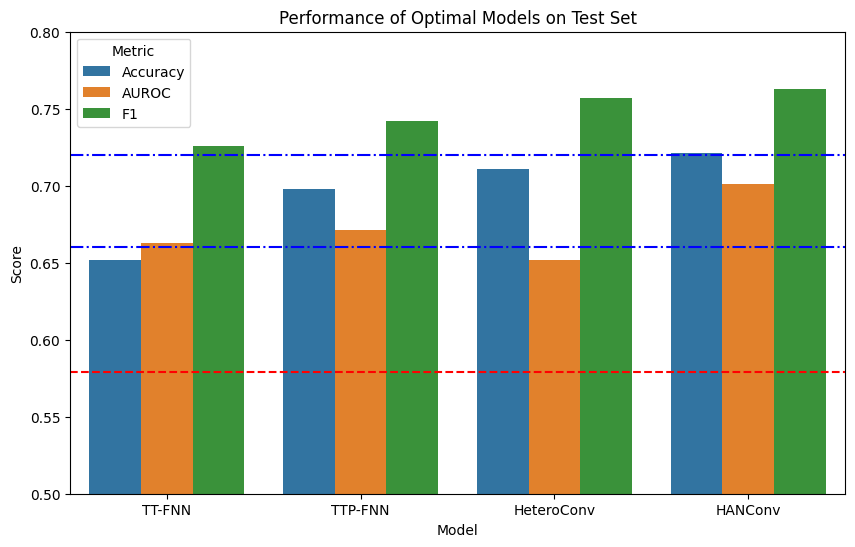

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melt)
plt.axhline(y=0.579, color='r', linestyle='--', label='Home Win Pct')
plt.axhline(y=.66, color='b', linestyle='-.')
plt.axhline(y=.72, color='b', linestyle='-.')
plt.ylim(0.5, 0.8)
plt.title('Performance of Optimal Models on Test Set')
plt.savefig("results_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
latex_table = paper_results_df.to_latex(index=False)  # Set index=False to exclude the index from the table
print(latex_table)


\begin{tabular}{lrrr}
\toprule
     Model &  Accuracy &  AUROC &    F1 \\
\midrule
    TT-FNN &     0.652 &  0.663 & 0.726 \\
   TTP-FNN &     0.698 &  0.671 & 0.742 \\
HeteroConv &     0.711 &  0.652 & 0.757 \\
   HANConv &     0.721 &  0.701 & 0.763 \\
\bottomrule
\end{tabular}



C:\Users\Joe\AppData\Local\Temp\ipykernel_24116\1128174614.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = paper_results_df.to_latex(index=False)  # Set index=False to exclude the index from the table


In [19]:
team_features_desc = pd.read_csv('C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\team_features_desc.csv')
player_features_desc = pd.read_csv('C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\player_features_desc.csv')

In [20]:
latex_table = team_features_desc.to_latex(index=False)  # Set index=False to exclude the index from the table
print(latex_table)

\begin{tabular}{llll}
\toprule
      Feature &                   Description & Dtype (original -> transformed) & Domain \\
\midrule
      AVG\_FGM &              Field Goals Made &                    Int -> float &  [0,1] \\
      AVG\_FGA &         Field Goals Attempted &                    Int -> float &  [0,1] \\
   AVG\_FG\_PCT &            Field Goal Percent &                  float -> float &  [0,1] \\
     AVG\_FG3M &            Three-Pointer Made &                    Int -> float &  [0,1] \\
     AVG\_FG3A &       Three-Pointer Attempted &                    Int -> float &  [0,1] \\
  AVG\_FG3\_PCT &         Three-Pointer Percent &                  float -> float &  [0,1] \\
      AVG\_FTM &              Free-Throws Made &                    Int -> float &  [0,1] \\
      AVG\_FTA &         Free-Throws Attempted &                    Int -> float &  [0,1] \\
   AVG\_FT\_PCT &           Free-Throws Percent &                  float -> float &  [0,1] \\
     AVG\_OREB &            

C:\Users\Joe\AppData\Local\Temp\ipykernel_24116\2099743340.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = team_features_desc.to_latex(index=False)  # Set index=False to exclude the index from the table


In [21]:
latex_table = player_features_desc.to_latex(index=False)  # Set index=False to exclude the index from the table
print(latex_table)

\begin{tabular}{llll}
\toprule
         Feature &                             Description & Dtype (original -> transformed) & Domain \\
\midrule
       AVG\_MIN\_x &                          Minutes Played &                   time -> float &  [0,1] \\
         AVG\_FGM &                        Field Goals Made &                    Int -> float &  [0,1] \\
         AVG\_FGA &                   Field Goals Attempted &                    Int -> float &  [0,1] \\
      AVG\_FG\_PCT &                      Field Goal Percent &                  float -> float &  [0,1] \\
        AVG\_FG3M &                      Three-Pointer Made &                    Int -> float &  [0,1] \\
        AVG\_FG3A &                 Three-Pointer Attempted &                    Int -> float &  [0,1] \\
     AVG\_FG3\_PCT &                   Three-Pointer Percent &                  float -> float &  [0,1] \\
         AVG\_FTM &                        Free-Throws Made &                    Int -> float &  [0,1] \\
    

C:\Users\Joe\AppData\Local\Temp\ipykernel_24116\1432497800.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = player_features_desc.to_latex(index=False)  # Set index=False to exclude the index from the table


In [23]:
final_params_df = pd.read_csv('C:\\Users\\Joe\\Desktop\\Data Science Masters\\Tufts Spring 2023\\CS 150\\Final Project\\optimal_HANCONV_params.csv')

In [24]:
latex_table = final_params_df.to_latex(index=False)  # Set index=False to exclude the index from the table
print(latex_table)

\begin{tabular}{lr}
\toprule
 Hyperparameter &   Value \\
\midrule
    Hidden Dims & 24.0000 \\
Attention Heads &  4.0000 \\
   Dropout Rate &  0.2500 \\
  Learning Rate &  0.0250 \\
          Gamma &  0.9900 \\
   Weight Decay &  0.0005 \\
     Batch Size & 16.0000 \\
\bottomrule
\end{tabular}



C:\Users\Joe\AppData\Local\Temp\ipykernel_24116\1240455645.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = final_params_df.to_latex(index=False)  # Set index=False to exclude the index from the table
